In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
import geopandas as gpd

url = 'https://opendata.arcgis.com/datasets/1365a2d9cb344b67999dd825c99cb1a5_0.geojson'
original_df = gpd.read_file(url)

In [3]:
df = (
    pd.DataFrame(original_df)
    .loc[:,['Meldingen', 'Ziekenhuisopnamen', 'Overleden', 'Datum']]
    .assign(Date=lambda df: pd.to_datetime(df['Datum'], infer_datetime_format=True))
    .assign(Date=lambda df: df['Date'].dt.round('D'))
    .rename(
        columns={
            'Meldingen': 'Cases',
            'Ziekenhuisopnamen': 'Hospitalisation',
            'Overleden': 'Deaths'
        }    
    )
    .groupby(by='Date')
    .sum()
)

In [6]:
def show_development_over_time(df, quantity, window=7, start_date='2020-10-01', y='absolute', save=False):
    assert quantity in df.columns, f'{quantity} not in columns {df.columns}'
    df = (
        df
        .assign(
            new=lambda df: df[quantity].diff(),
            newMA=lambda df: df['new'].rolling(window=window, center=True).mean(),
            growth_new=lambda df: df['new'].diff(),
            growth_newMA=lambda df: df['growth_new'].rolling(window=window, center=True).mean(),
            pct_new=lambda df: 100*df['new'].pct_change(),
            pct_nieuwMA=lambda df: df['pct_new'].rolling(window=window, center=True).mean()
        )
        .rename(columns={
            'newMA':f'new{window}MA',
            'growth_newMA':f'growth_new{window}MA',
            'pct_nieuwMA':f'pct_new{window}MA',
        })
    )
    
    fig, ax1 = plt.subplots(figsize=(20,5), dpi=150)
    subdf = df.loc[start_date:]
    
    lines = []
    labels = []

    color = 'tab:red'
    bar = ax1.bar(x=subdf.index, height=subdf['new'], color=color, label=f'New {quantity.lower()}', alpha=0.3)
    line = ax1.plot(subdf.index, subdf[f'new{window}MA'], color=color, label=f'New {quantity.lower()} {window}MA')
    ax1.set_ylabel(f'New {quantity}', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.tick_params(axis='x', rotation=90)
    
    lines.append(line[0])
    lines.append(bar)

    ax2 = ax1.twinx()

    color = 'tab:blue'
    
    if y=='absolute':
        bar = ax2.bar(x=subdf.index, height=subdf['growth_new'], color=color, label=f'Growth new {quantity.lower()}', alpha=0.3)
        line = ax2.plot(subdf.index, subdf[f'growth_new{window}MA'], color=color, label=f'Growth new {quantity.lower()} {window}MA')
        ax2.set_ylabel(f'Growth new {quantity.lower()}', color=color)
    if y=='relative':
        bar = ax2.bar(x=subdf.index, height=subdf['pct_new'], color=color, label=f'Growth new {quantity.lower()} (in %)', alpha=0.3)
        line = ax2.plot(subdf.index, subdf[f'pct_new{window}MA'], color=color, label=f'Growth new {quantity.lower()} {window}MA (in %)')
        ax2.set_ylabel(f'Growth new {quantity} (in %)', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    lines.append(line[0])
    lines.append(bar)
    
    labels = [line.get_label() for line in lines]
    
    plt.legend(lines, labels, loc='upper left')
    title = f'Corona {quantity.lower()} in NL'
    plt.title(title)    
    plt.tight_layout()
    
    if save:
        filename = f'{title}.png'
        plt.savefig(filename)
        
    plt.show()

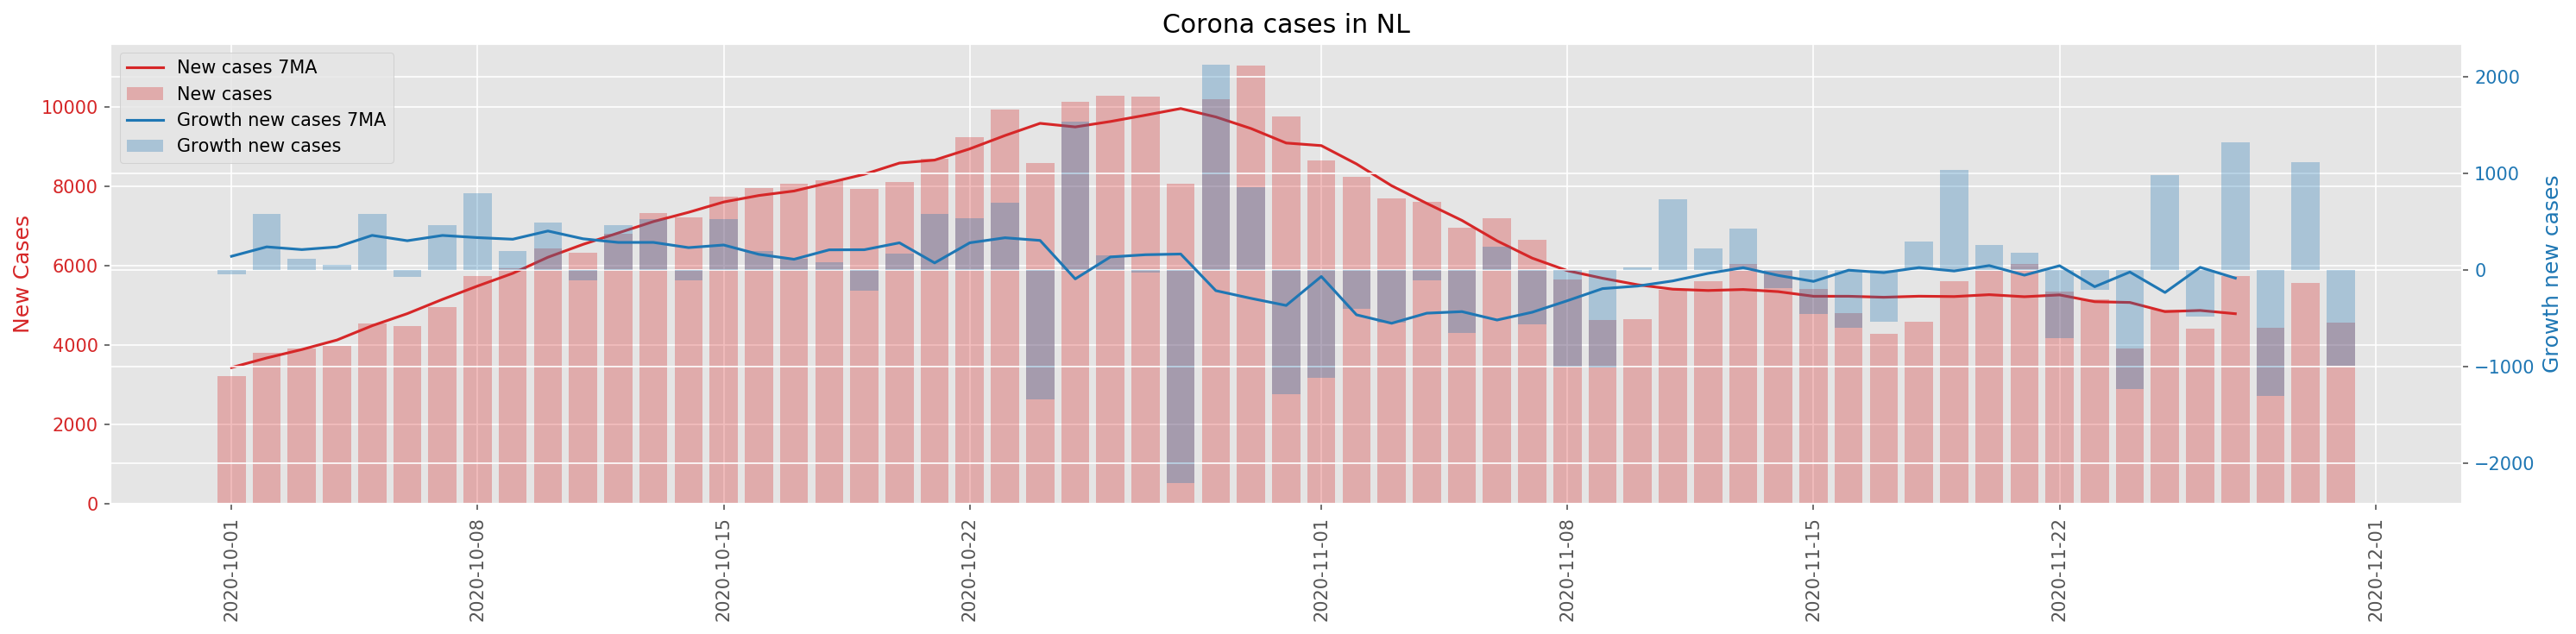

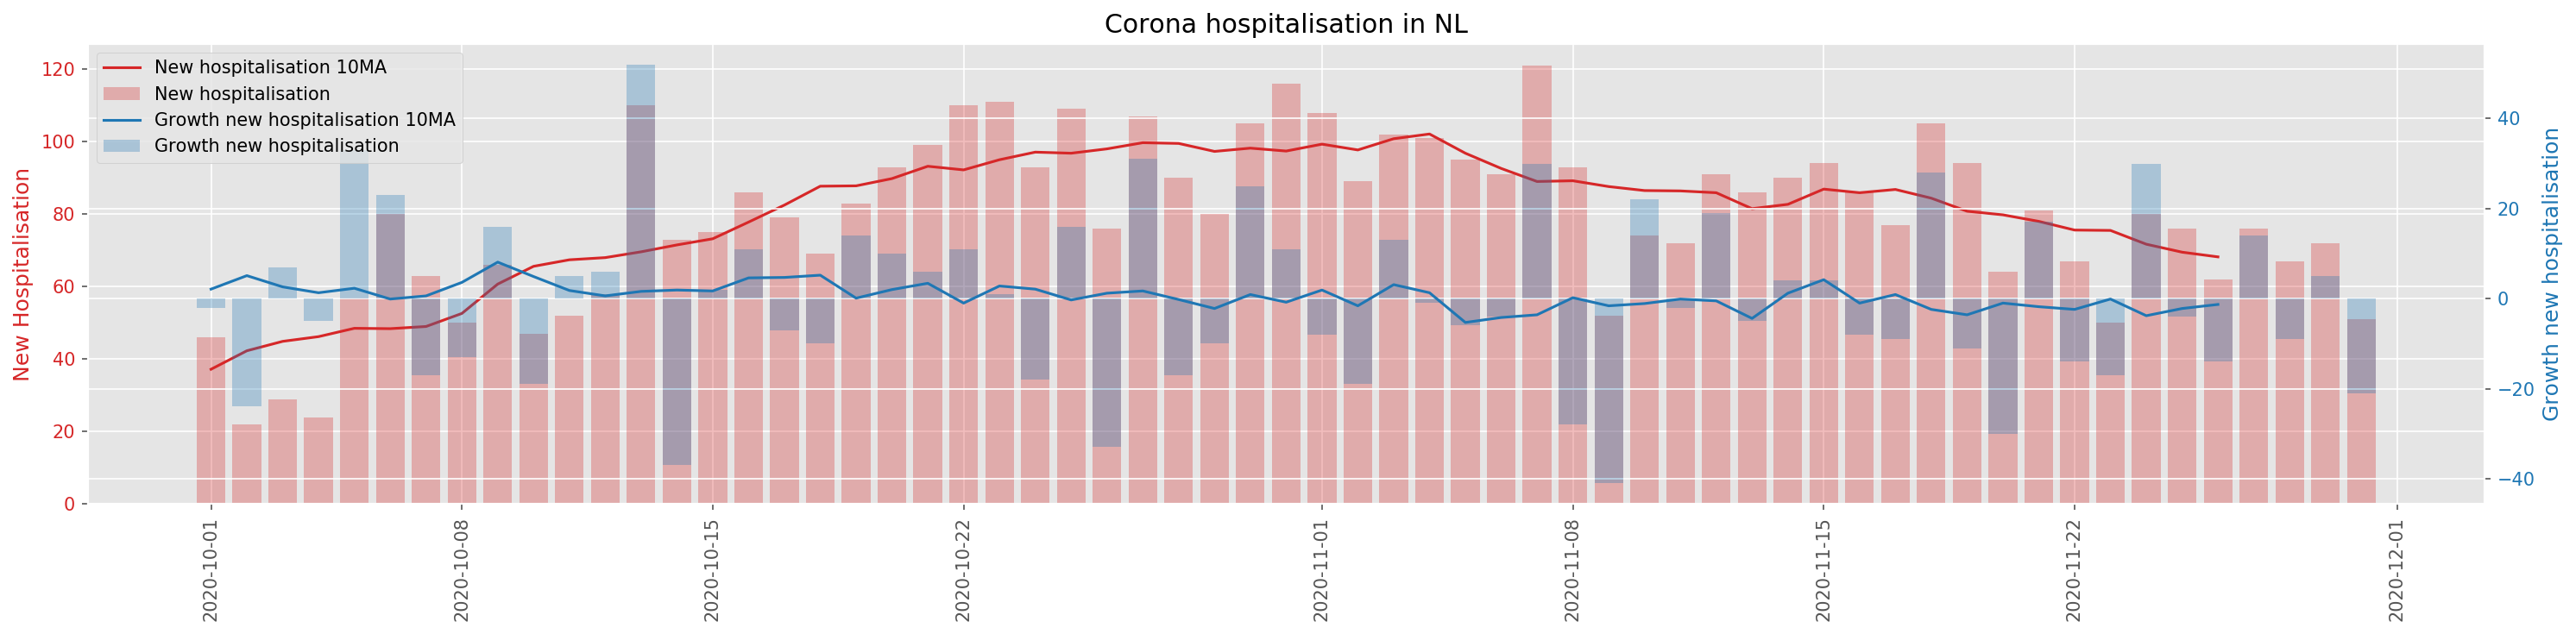

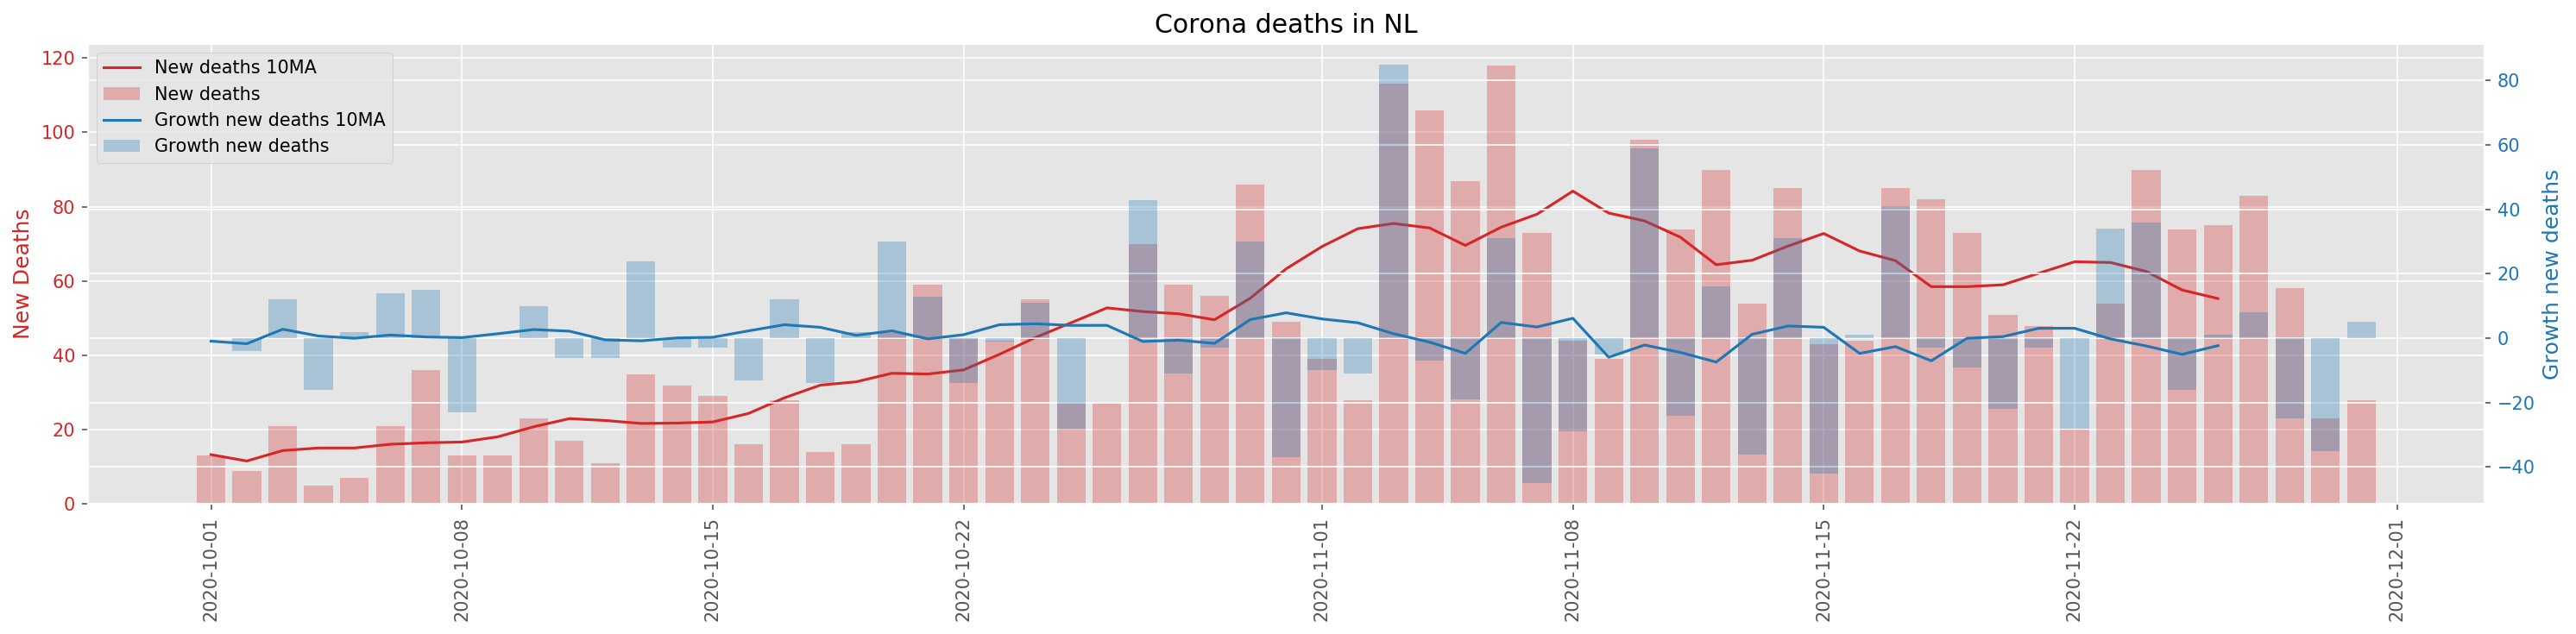

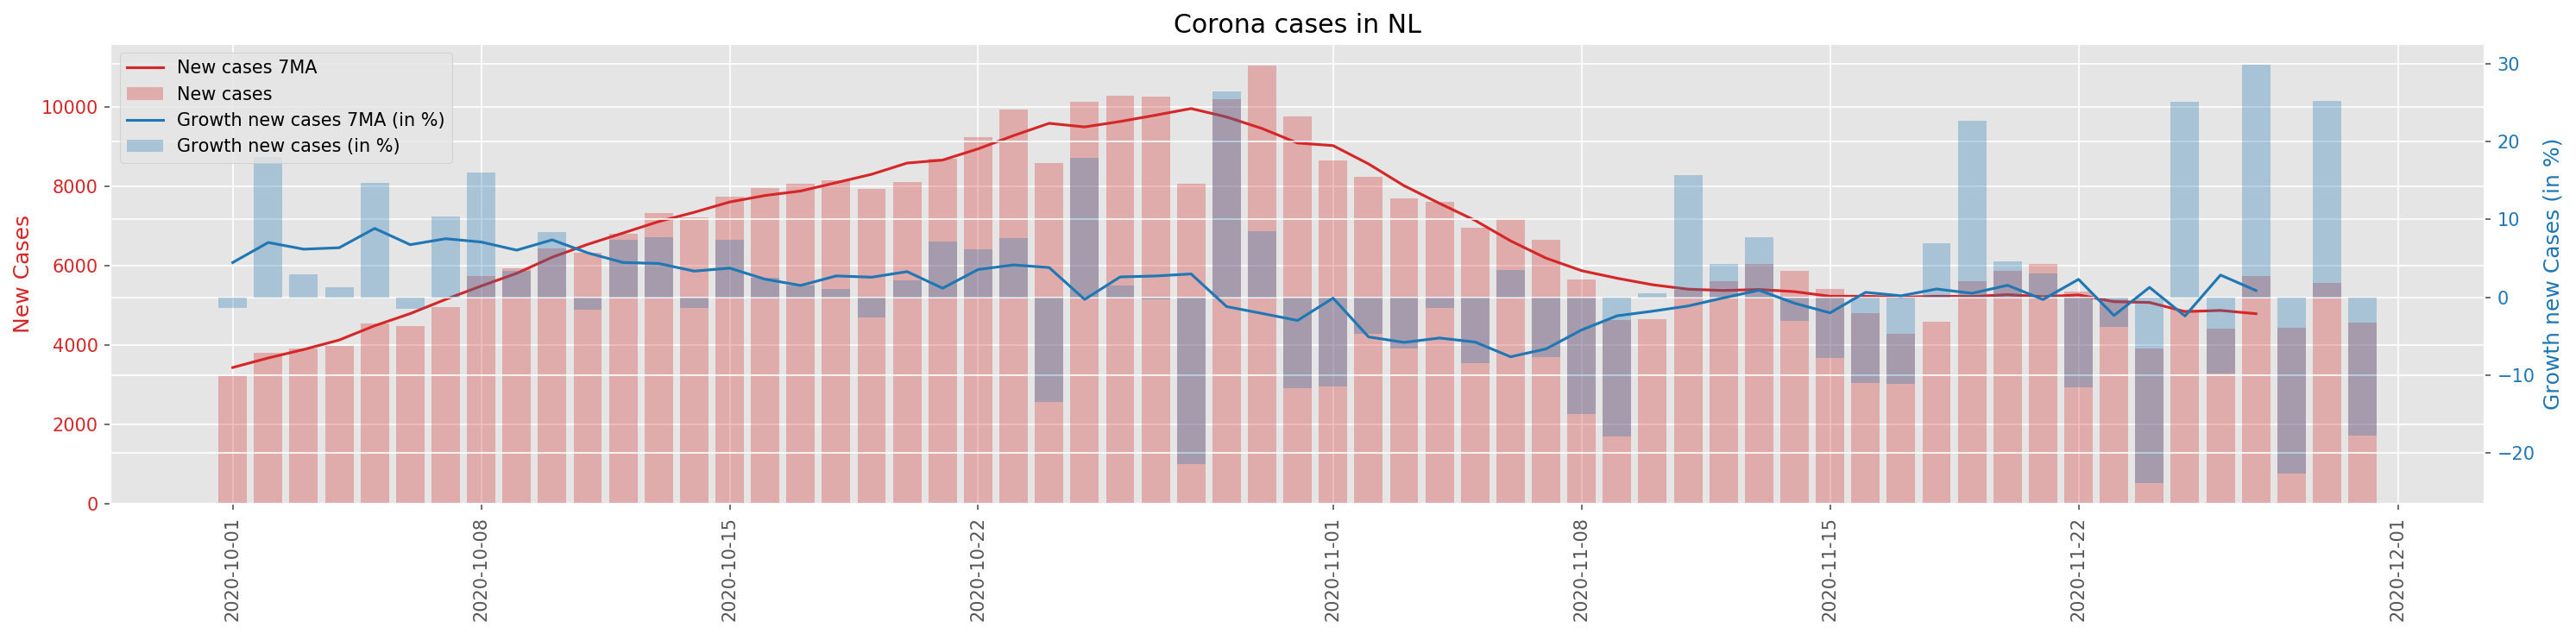

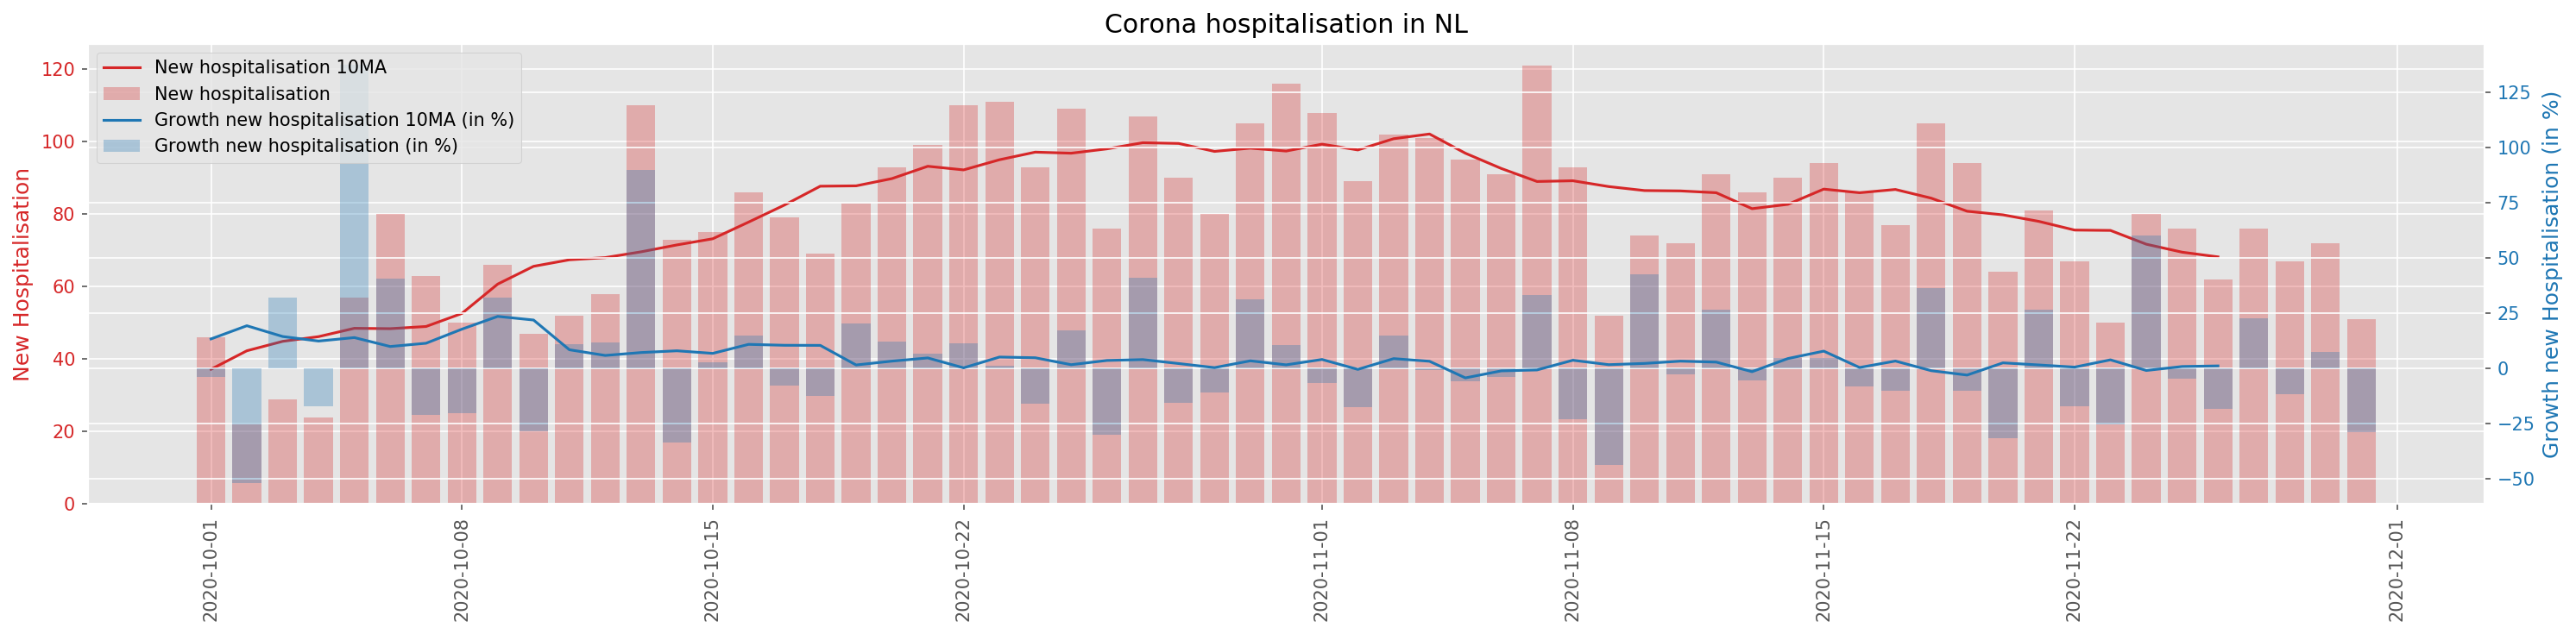

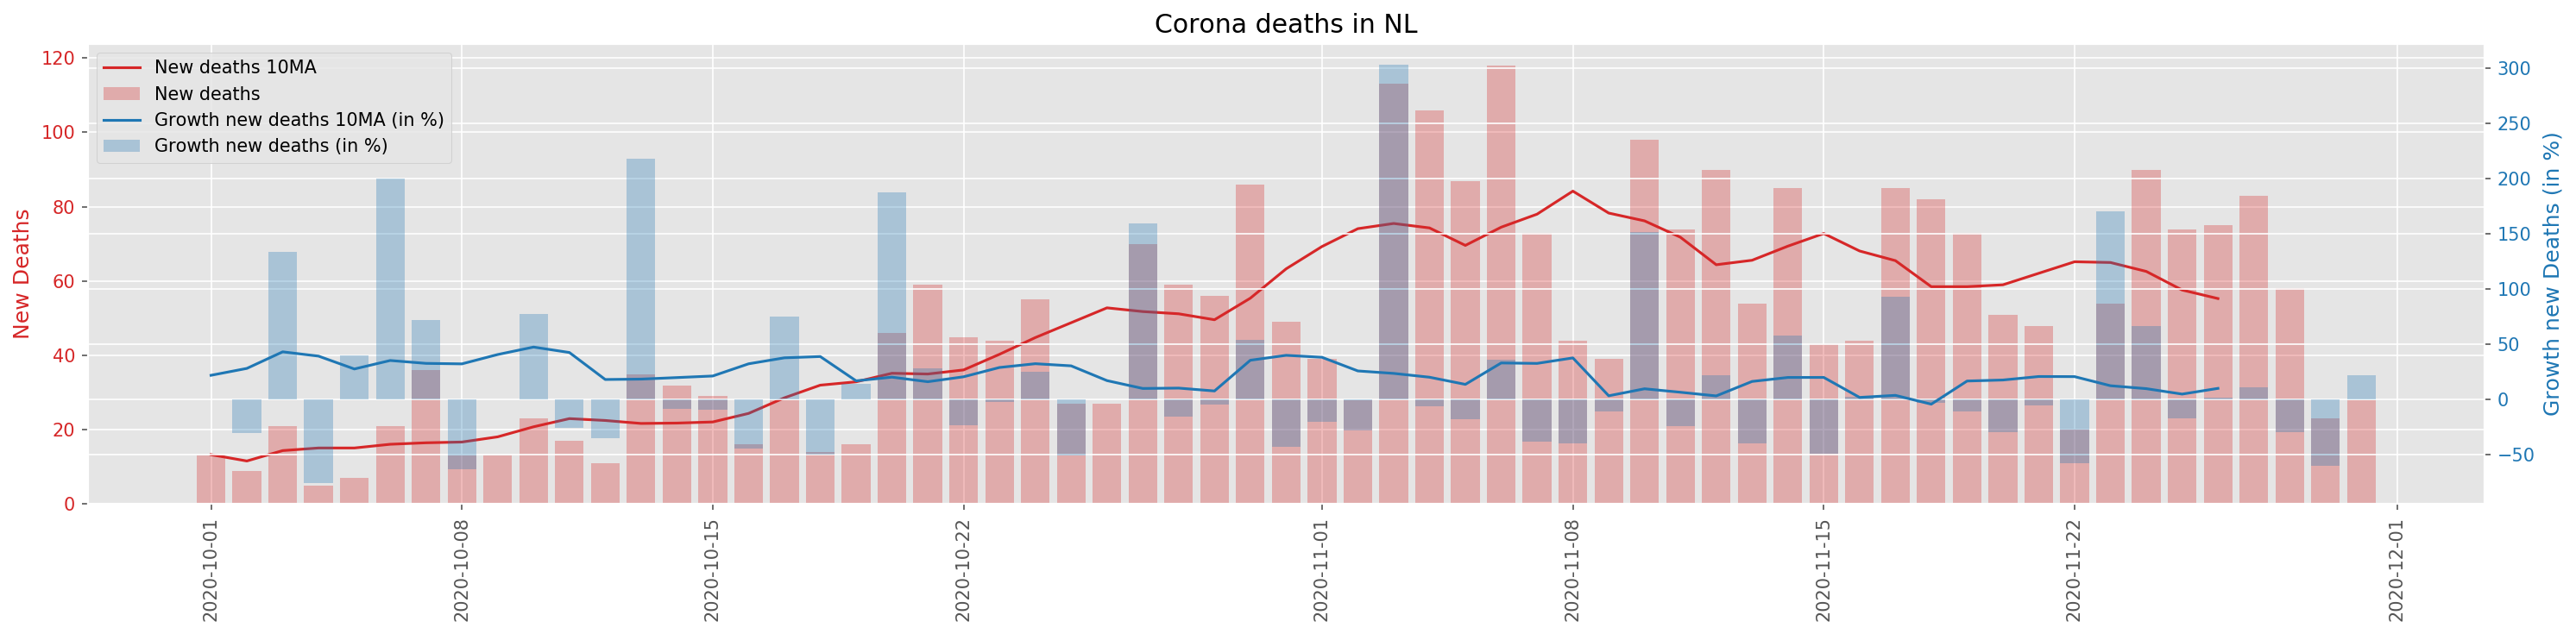

In [7]:
show_development_over_time(df, 'Cases', window=7, start_date='2020-10-01')
show_development_over_time(df, 'Hospitalisation', window=10, start_date='2020-10-01')
show_development_over_time(df, 'Deaths', window=10, start_date='2020-10-01')

show_development_over_time(df, 'Cases', window=7, start_date='2020-10-01', y='relative', save=True)
show_development_over_time(df, 'Hospitalisation', window=10, start_date='2020-10-01', y='relative')
show_development_over_time(df, 'Deaths', window=10, start_date='2020-10-01', y='relative')